In [3]:
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from models.FasterRCNN.model import DotaLightningModel
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch

In [4]:
CKPT_PATH = "checkpoints/dota-epoch=182-map_50=0.544.ckpt"
model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
for param in model.backbone.parameters():
    param.requires_grad = False
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 17)
model = DotaLightningModel.load_from_checkpoint(CKPT_PATH, model=model, optimizer=None)
model = model.eval()

In [1]:
# IMG_PATH = "../data/dota-mod/images/val/P2789__640__1536___3072.jpg"
# IMG_PATH = "../data/dota-mod/images/val/P0007__640__512___512.jpg"
IMG_PATH = "image.png"

In [5]:
import torchvision
img = torchvision.io.read_image(IMG_PATH).unsqueeze(0).float() / 255.0
img = img.to('cuda')
predictions = model(img)

In [ ]:
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CLASS_NAMES = [
    "UNUSED_LABEL_0",
    "plane",
    "ship",
    "storage tank",
    "baseball diamond",
    "tennis court",
    "basketball court",
    "ground track field",
    "harbor",
    "bridge",
    "large vehicle",
    "small vehicle",
    "helicopter",
    "roundabout",
    "soccer ball field",
    "swimming pool",
    "container crane"
]

def plot_image_with_boxes(image_path, predictions, threshold=0.5):
    """
    Plots an image with bounding boxes, labels, and scores, filtering by a score threshold.
    Eliminates all white borders, showing only the image and bounding boxes.
    Places labels intelligently to avoid overlaps.

    Args:
        image_path (str): Path to the image file.
        predictions (list): A list of dictionaries, where each dictionary contains
            'boxes' (tensor), 'labels' (tensor), and 'scores' (tensor).
        threshold (float): Minimum score threshold for displaying detections. Default is 0.5.
    """
    try:
        img = Image.open(image_path)
        np_img = np.array(img.convert("RGB"))
    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Create a PIL Image for drawing
    pil_img = Image.fromarray(np_img)
    draw = ImageDraw.Draw(pil_img)
    
    # Get image dimensions
    img_width, img_height = pil_img.size
    
    detection_count = 0  # Keep track of how many boxes are drawn
    
    # Create a "occupied" map to track where labels are already placed
    # This will be a 2D map to track occupied regions
    label_occupied = np.zeros((img_height, img_width), dtype=bool)

    # First, process all predictions and get all bounding boxes
    all_boxes = []
    all_labels = []
    all_scores = []

    for prediction in predictions:
        # Skip predictions without required keys
        if not all(key in prediction for key in ['boxes', 'labels', 'scores']):
            print("Warning: Skipping prediction due to missing keys ('boxes', 'labels', 'scores').")
            continue

        boxes = prediction['boxes']
        labels = prediction['labels']
        scores = prediction['scores']

        # Ensure tensors are on CPU for processing
        if isinstance(boxes, torch.Tensor):
            boxes = boxes.cpu()
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu()
        if isinstance(scores, torch.Tensor):
            scores = scores.cpu()

        # Filter by threshold
        if threshold > 0:
            keep_indices = scores > threshold
            boxes = boxes[keep_indices]
            labels = labels[keep_indices]
            scores = scores[keep_indices]

        # Validate lengths match
        if not (len(boxes) == len(labels) == len(scores)):
            print(f"Warning: Mismatch in lengths after filtering - boxes({len(boxes)}), labels({len(labels)}), scores({len(scores)}). Skipping this prediction.")
            continue

        # Add to our lists
        for box, label, score in zip(boxes, labels, scores):
            all_boxes.append(box)
            all_labels.append(label)
            all_scores.append(score)

    # Try to load a font, or use default if not available
    try:
        # Try to use a common font that should be available
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        # If that fails, use default font
        font = ImageFont.load_default()

    # First draw all bounding boxes
    for box in all_boxes:
        try:
            x1, y1, x2, y2 = [int(coord) for coord in box.tolist()]
            # Draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)
        except Exception as e:
            print(f"Error drawing box: {e}")
            continue

    # Sort boxes by y-coordinate to process from top to bottom
    # This helps in positioning labels in a more organized way
    sorted_indices = sorted(range(len(all_boxes)), key=lambda i: all_boxes[i][1])
    
    # Draw labels with smart positioning
    for idx in sorted_indices:
        try:
            box = all_boxes[idx]
            label_idx = all_labels[idx]
            score = all_scores[idx]
            
            x1, y1, x2, y2 = [int(coord) for coord in box.tolist()]
            label_idx = int(label_idx.item())  # Convert label to integer index
            score_val = float(score.item())  # Convert score to float

            # Get class name safely
            if 0 < label_idx < len(CLASS_NAMES):
                class_name = CLASS_NAMES[label_idx]
            else:
                class_name = f"Unknown({label_idx})"
            
            # Draw text with background
            text = f"{class_name}: {score_val:.2f}"
            
            # Determine text dimensions
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Try different positions for the label in this priority order:
            # 1. Below the box
            # 2. Inside the box at the bottom
            # 3. Inside the box at the top
            # 4. Above the box
            
            positions_to_try = [
                (x1, min(img_height - text_height - 2, y2 + 2)),  # Below box
                (x1, max(0, y2 - text_height - 2)),              # Inside box, bottom
                (x1, max(0, y1 + 2)),                           # Inside box, top
                (x1, max(0, y1 - text_height - 2))              # Above box
            ]
            
            # Check if text would go off right edge and adjust if needed
            for i, (pos_x, pos_y) in enumerate(positions_to_try):
                if pos_x + text_width > img_width:
                    positions_to_try[i] = (img_width - text_width - 2, pos_y)
            
            # Find a non-overlapping position
            final_pos = None
            for pos_x, pos_y in positions_to_try:
                # Check if this position would overlap with existing labels
                overlap = False
                
                # Define the rectangle for this potential text position
                text_rect_top = max(0, int(pos_y))
                text_rect_bottom = min(img_height, int(pos_y + text_height))
                text_rect_left = max(0, int(pos_x))
                text_rect_right = min(img_width, int(pos_x + text_width))
                
                # Check if any part of this rectangle is already occupied
                if np.any(label_occupied[text_rect_top:text_rect_bottom, text_rect_left:text_rect_right]):
                    overlap = True
                
                # If no overlap, use this position
                if not overlap:
                    final_pos = (pos_x, pos_y)
                    # Mark this area as occupied
                    label_occupied[text_rect_top:text_rect_bottom, text_rect_left:text_rect_right] = True
                    break
            
            # If all positions overlap, use the first one anyway
            if final_pos is None:
                final_pos = positions_to_try[0]
                # Mark as occupied even though there's overlap
                text_rect_top = max(0, int(final_pos[1]))
                text_rect_bottom = min(img_height, int(final_pos[1] + text_height))
                text_rect_left = max(0, int(final_pos[0]))
                text_rect_right = min(img_width, int(final_pos[0] + text_width))
                label_occupied[text_rect_top:text_rect_bottom, text_rect_left:text_rect_right] = True
            
            # Draw text background
            final_text_bbox = draw.textbbox(final_pos, text, font=font)
            draw.rectangle(final_text_bbox, fill="lime")
            
            # Draw text
            draw.text(final_pos, text, fill="black", font=font)
            
            detection_count += 1
        except Exception as e:
            print(f"Error processing a filtered box/label/score: {e}")
            continue  # Skip this specific box if error occurs

    print(f"Drew {detection_count} detection boxes")
    
    # Save directly with PIL - no matplotlib involved
    pil_img.save("detection_result.png")
    
    # If you're in a notebook environment, you can display the image
    # If not in a notebook, this line can be removed
    try:
        from IPython.display import display
        display(pil_img)
    except ImportError:
        # Not in an IPython environment, just show we're done
        print("Image saved to detection_result.png")

Drew 15 detection boxes


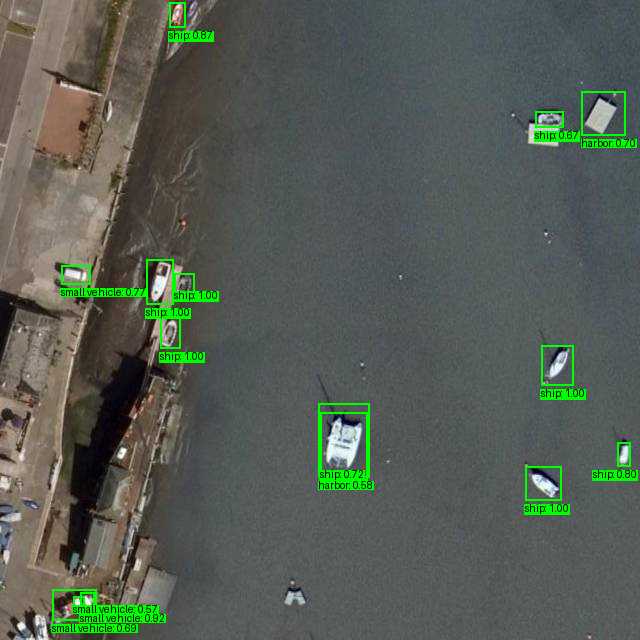

In [23]:

plot_image_with_boxes(IMG_PATH, predictions, threshold=0.5)


In [8]:
import torch
import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import DataLoader
import argparse
import logging
import os

# Assuming these files are in the same directory or accessible via PYTHONPATH
# Ensure const.py defining DOTA_DIR/DOTA_MOD_DIR is also accessible
try:
    from models.FasterRCNN.dataset import DotaDataModule # Assuming dataset.py contains DotaDataModule
    from models.FasterRCNN.model import DotaLightningModel # Assuming model.py contains DotaLightningModel
    # Import the actual base model architecture used within DotaLightningModel
    from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
    # Import the predictor head used
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
except ImportError as e:
    print(f"Error importing necessary modules: {e}")
    print("Please ensure dataset.py, model.py, FastRCNNPredictor, and any required constants (like DOTA_DIR) are accessible.")
    exit(1)

# --- Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


DOTA_CLASSES = [
    # "UNUSED_LABEL_0",
    "plane",
    "ship",
    "storage tank",
    "baseball diamond",
    "tennis court",
    "basketball court",
    "ground track field",
    "harbor",
    "bridge",
    "large vehicle",
    "small vehicle",
    "helicopter",
    "roundabout",
    "soccer ball field",
    "swimming pool",
    "container crane"
]

CLASS_MAP = {i + 1: name for i, name in enumerate(DOTA_CLASSES)}
NUM_CLASSES = len(DOTA_CLASSES) # Now 16 based on user code.

def filter_predictions(outputs, confidence_threshold):
    """
    Filters model predictions based on a confidence score threshold.

    Args:
        outputs (list[dict]): List of dictionaries, one per image, containing
                               'boxes', 'scores', 'labels'.
        confidence_threshold (float): The threshold to keep predictions.

    Returns:
        list[dict]: List of dictionaries with filtered predictions.
    """
    filtered_outputs = []
    for output in outputs:
        if 'scores' not in output:
            logger.warning("Output dictionary missing 'scores' key. Skipping filtering for this item.")
            filtered_outputs.append(output) # Append unfiltered if scores are missing
            continue

        scores = output['scores']
        mask = scores >= confidence_threshold

        # Ensure keys exist before indexing
        filtered_output = {
            'boxes': output['boxes'][mask] if 'boxes' in output else torch.empty((0, 4), device=scores.device),
            'scores': scores[mask],
            'labels': output['labels'][mask] if 'labels' in output else torch.empty(0, dtype=torch.long, device=scores.device)
        }
        filtered_outputs.append(filtered_output)
    return filtered_outputs

def evaluate(model_path, batch_size, num_workers, confidence_threshold):
    """
    Loads the model, runs evaluation on the validation set, and prints per-class mAP.

    Args:
        model_path (str): Path to the saved PyTorch Lightning checkpoint (.ckpt).
        batch_size (int): Batch size for the validation DataLoader.
        num_workers (int): Number of workers for the DataLoader.
        confidence_threshold (float): Minimum confidence score for predictions to be evaluated.
    """

    if not os.path.exists(model_path):
         logger.error(f"Model checkpoint not found at: {model_path}")
         return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    logger.info("Setting up data module...")
    try:
        data_module = DotaDataModule(batch_size=batch_size, num_workers=num_workers, transforms=None) # Use appropriate eval transforms if needed
        data_module.setup("validate") # Or "test" if evaluating on the test set
        val_loader = data_module.val_dataloader()
    except Exception as e:
        logger.error(f"Error setting up data module: {e}")
        return

    if not val_loader:
        logger.error("Validation dataloader could not be created. Check dataset paths and setup.")
        return
    logger.info(f"Validation dataset loaded with {len(val_loader.dataset)} samples.")

    logger.info(f"Loading model from checkpoint using user-provided method: {model_path}")
    try:
        weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        base_model = fasterrcnn_resnet50_fpn_v2(weights=weights) # Load with default head first

        for param in base_model.backbone.parameters():
            param.requires_grad = False

        in_features = base_model.roi_heads.box_predictor.cls_score.in_features
        # Use NUM_CLASSES + 1 for the predictor (object classes + background)
        base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1) # Should be 17

        lightning_model = DotaLightningModel.load_from_checkpoint(
            model_path,
            model=base_model,
            optimizer=None, 
            map_location=device
        )


        logger.info("Model loaded successfully.")

    except FileNotFoundError:
        logger.error(f"Model checkpoint file not found at {model_path}")
        return
    except TypeError as e:
        logger.error(f"TypeError during model loading: {e}")
        logger.error("This might indicate an issue with arguments passed to load_from_checkpoint or DotaLightningModel.__init__.")
        logger.error("Ensure DotaLightningModel.__init__ can handle the 'model' argument and potentially 'optimizer=None'.")
        return
    except KeyError as e:
         logger.error(f"Error loading state_dict from checkpoint: Missing key {e}.")
         logger.error("Ensure the checkpoint file is valid and compatible with the model structure.")
         return
    except RuntimeError as e:
        logger.error(f"Error loading state_dict: {e}")
        logger.error("This often means the model architecture defined here doesn't match the one in the checkpoint.")
        logger.error(f"Ensure the base model, frozen layers, and predictor head match the saved checkpoint.")
        return
    except Exception as e:
        logger.error(f"An unexpected error occurred loading the model: {e}")
        return

    model = lightning_model
    model.to(device)
    model.eval()

    logger.info("Initializing MeanAveragePrecision metric...")
    metric = MeanAveragePrecision(class_metrics=True, iou_thresholds=[0.5])
    metric.to(device)

    logger.info(f"Starting evaluation with confidence threshold: {confidence_threshold}...")
    with torch.no_grad(): # Disable gradient calculations for inference
        for i, batch in enumerate(val_loader):
            try:
                images, targets = batch
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model(images) 

                filtered_outputs = filter_predictions(outputs, confidence_threshold)

                metric.update(filtered_outputs, targets)

                if (i + 1) % 50 == 0: 
                     logger.info(f"Processed batch {i+1}/{len(val_loader)}")

            except Exception as e:
                logger.error(f"Error during evaluation loop (batch {i}): {e}")
                continue

    logger.info("Evaluation finished. Computing final metrics...")
    try:
        results = metric.compute()
    except Exception as e:
        logger.error(f"Error computing metrics: {e}")
        logger.error("This might happen if no predictions met the threshold or if there were issues during metric updates.")
        return

    print("\n--- Evaluation Results ---")
    print(f"Model Checkpoint: {model_path}")
    print(f"Confidence Threshold: {confidence_threshold}")
    print(f"IoU Threshold: 0.5")

    if 'map_per_class' in results and 'classes' in results:
        map_per_class = results['map_per_class']
        classes = results['classes']

        if map_per_class.numel() == 0 or classes.numel() == 0:
             print("\nNo per-class results computed. Possible reasons:")
             print("  - No ground truth objects were present for any class in the validation set.")
             print("  - No predictions were made (or survived filtering) for any class.")
             print("  - Issue with label matching between predictions and targets.")
        else:
            print("\nMean Average Precision (mAP @ 0.5 IoU) per Class:")
            map_per_class = map_per_class.cpu()
            classes = classes.cpu()

            results_dict = {cls_idx.item(): ap.item() for cls_idx, ap in zip(classes, map_per_class)}

            found_any_class = False
            for class_idx, class_name in CLASS_MAP.items(): 
                 if ap is not None:
                     print(f"  - {class_name:<20} (ID: {class_idx:2d}): {ap:.4f}")
                     found_any_class = True
                 else:
                     print(f"  - {class_name:<20} (ID: {class_idx:2d}): Not computed (No GT or valid Preds)")

            if not found_any_class:
                 print("  -> No AP values were computed for any known class.")

    else:
        print("\nPer-class results ('map_per_class', 'classes') not found in metric output.")
        print("  - Ensure 'class_metrics=True' was set for MeanAveragePrecision.")
        print(f"  - Available keys in results: {results.keys()}")

    overall_map = -1.0
    if 'map_50' in results:
         overall_map = results['map_50'].item()
         print(f"\nOverall mAP @ 0.5 IoU: {overall_map:.4f}")
    elif 'map' in results: 
         overall_map = results['map'].item()
         print(f"\nOverall mAP (default thresholds): {overall_map:.4f}")
    else:
        print("\nOverall mAP ('map_50' or 'map') not found in metric output.")

    logger.info("Evaluation script finished.")

evaluate(
    model_path=CKPT_PATH,
    batch_size=4,
    num_workers=4,
    confidence_threshold=0.5
)


2025-04-30 19:00:40,478 - INFO - Using device: cuda
2025-04-30 19:00:40,478 - INFO - Setting up data module...
2025-04-30 19:00:45,220 - INFO - Found 9989 valid labeled images in 'train'.
2025-04-30 19:00:46,633 - INFO - Found 3202 valid labeled images in 'val'.
2025-04-30 19:00:46,634 - WARNING - ⚠️ Test dataset skipped — no label files found.
2025-04-30 19:00:46,635 - INFO - Validation dataset loaded with 3202 samples.
2025-04-30 19:00:46,635 - INFO - Loading model from checkpoint using user-provided method: checkpoints/dota-epoch=182-map_50=0.544.ckpt
2025-04-30 19:00:47,489 - INFO - Model loaded successfully.
2025-04-30 19:00:47,492 - INFO - Initializing MeanAveragePrecision metric...
2025-04-30 19:00:47,493 - INFO - Starting evaluation with confidence threshold: 0.5...
2025-04-30 19:00:55,415 - INFO - Processed batch 50/801
2025-04-30 19:01:03,006 - INFO - Processed batch 100/801
2025-04-30 19:01:10,522 - INFO - Processed batch 150/801
2025-04-30 19:01:18,073 - INFO - Processed ba

KeyboardInterrupt: 

Loading model...
Model loaded on cuda and set to eval mode.
Loading and preprocessing image: ../data/dota-mod/images/val/P0007__640__512___512.jpg
Performing forward pass through backbone and RPN...
Generated 1000 RPN proposals.
Visualizing top 500 proposals...
Saving figure...
Figure saved.


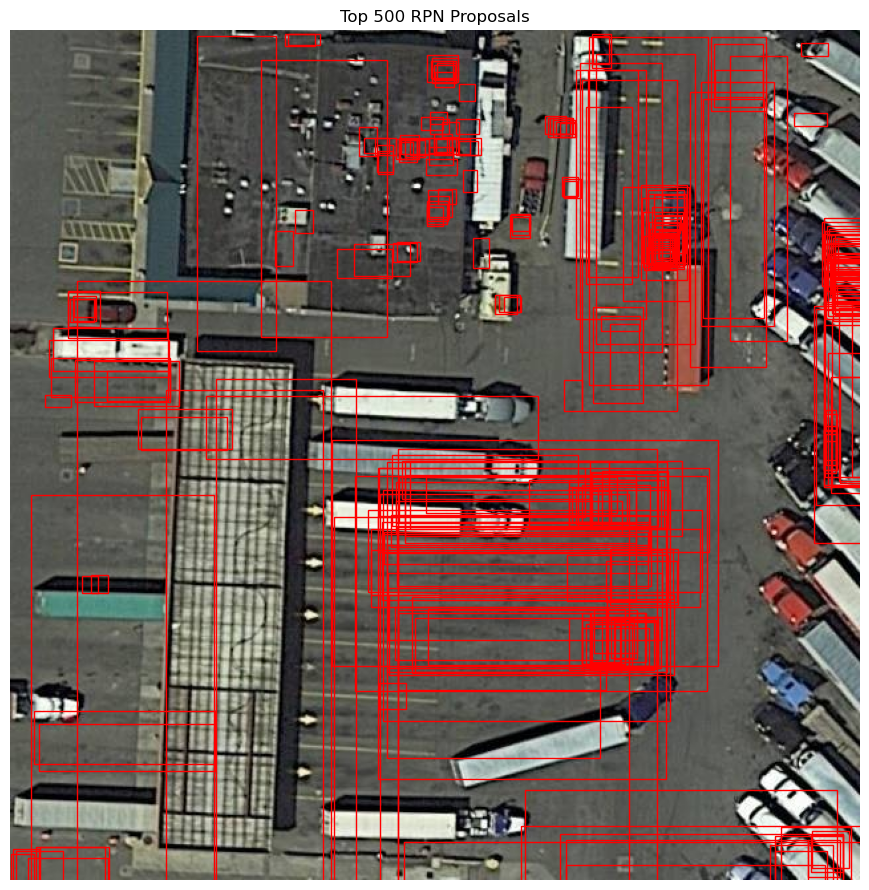

In [ ]:
import torch
import torchvision.transforms as T
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Assuming your model definition files are accessible
from models.FasterRCNN.model import DotaLightningModel 
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- Configuration ---
CKPT_PATH = "checkpoints/dota-epoch=182-map_50=0.544.ckpt"
IMAGE_PATH = "../data/dota-mod/images/val/P0007__640__512___512.jpg"
NUM_PROPOSALS_TO_SHOW = 500 # Show top N proposals
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# --- 1. Load Model ---
print("Loading model...")
base_model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

for param in base_model.backbone.parameters():
    param.requires_grad = False
    
in_features = base_model.roi_heads.box_predictor.cls_score.in_features
base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 17) # Assuming 16 classes + 1 background


model = DotaLightningModel.load_from_checkpoint(
    CKPT_PATH, 
    model=base_model,
    optimizer=None,  
    map_location=DEVICE 
) 
model = model.model 
model.to(DEVICE) 
model.eval()     
print(f"Model loaded on {DEVICE} and set to eval mode.")

# --- 2. Load and Preprocess Image ---
print(f"Loading and preprocessing image: {IMAGE_PATH}")
img_pil = Image.open(IMAGE_PATH).convert("RGB")

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transforms = weights.transforms()
img_tensor = transforms(img_pil) 
images = [img_tensor.to(DEVICE)]

# --- 3. Perform Manual Forward Pass up to RPN ---
print("Performing forward pass through backbone and RPN...")
with torch.no_grad():

    original_image_sizes = [(img_pil.height, img_pil.width)] 
    
    processed_images, _ = model.transform(images, None) # Target is None for inference

    features = model.backbone(processed_images.tensors)

    proposals, proposal_losses = model.rpn(processed_images, features, None) 

rpn_proposals = proposals[0].cpu().numpy()
print(f"Generated {rpn_proposals.shape[0]} RPN proposals.")

# --- 4. Visualize Proposals ---
print(f"Visualizing top {NUM_PROPOSALS_TO_SHOW} proposals...")
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img_pil)

for i, box in enumerate(rpn_proposals):
    if i >= NUM_PROPOSALS_TO_SHOW:
        break
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    
    rect = patches.Rectangle(
        (x1, y1), 
        width, 
        height, 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    )
    
    ax.add_patch(rect)

ax.set_title(f"Top {NUM_PROPOSALS_TO_SHOW} RPN Proposals")
plt.axis('off')
plt.tight_layout()

# --- SAVE BEFORE SHOW ---
print("Saving figure...")
plt.savefig("top_rpn_proposals_500.png", dpi=300, bbox_inches='tight')
print("Figure saved.")

# --- THEN SHOW ---
plt.show()